# The Data
In this lab, we will use medical data to predict the likelihood of a person experiencing an exercise-induced heart attack.

Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain (“angina”) during exercise.

Although it is not a formal question on this assignment, you should begin by reading in the dataset and briefly exploring and summarizing the data, and by adjusting any variables that need cleaning.

In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, roc_auc_score, f1_score, roc_curve, classification_report)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.exceptions import ConvergenceWarning
import seaborn as sns


#suppress convergence warnings
warnings.simplefilter("ignore", ConvergenceWarning)
pd.options.mode.chained_assignment = None

In [81]:
# cleaning data
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.dropna(inplace=True)
ha[["sex", "cp", "restecg", "output"]] = ha[["sex", "cp", "restecg", "output"]].astype("object")
ha.describe()


,age,trtbps,chol,thalach
count,273.000000,273.000000,273.000000,273.000000
mean,54.347985,132.098901,246.860806,149.446886
std,9.163134,17.700358,52.569726,23.240707
min,29.000000,94.000000,126.000000,71.000000
25%,47.000000,120.000000,211.000000,133.000000
50%,56.000000,130.000000,240.000000,152.000000
75%,61.000000,140.000000,275.000000,166.000000
max,77.000000,200.000000,564.000000,202.000000


In [82]:
# make sure output column is int
ha["output"] = ha["output"].astype(int)

# Part One: Fitting the Models

This section asks you to create a final best model for each of the model types studied this week. For each, you should:

* Find the best model based on ROC AUC for predicting the target variable.

* Report the (cross-validated!) ROC AUC metric.

* Fit the final model.

* Output a confusion matrix; that is, the counts of how many observations fell into each predicted class for each true class.

* (Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You should include any hyperparameter tuning steps in your writeup as well.

## Q1: KNN

In [83]:
# specify x and y variables
X = ha.drop("output", axis = 1)
y = ha["output"]

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [84]:
# create column transformer
ct = ColumnTransformer([
    ("dummify", OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
     make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
],
remainder="passthrough")
#create pipeline
knn_pipeline = Pipeline(
    [("preprocessing", ct),
     ("classifier", KNeighborsClassifier())]
)
# specify parameters
params = {
    "classifier__n_neighbors": range(1, 25)
}

# perform grid search
knn_grid_search = GridSearchCV(knn_pipeline, params, cv=5, scoring="roc_auc")
knn_grid_search.fit(X_train, y_train)

# get best model and params
knn_best_model = grid_search.best_estimator_
knn_best_params = knn_grid_search.best_params_

knn_cv = cross_val_score(best_model, X_train, y_train, scoring='roc_auc', cv=5).mean()

print("Best Parameters: ", knn_best_params)
print("Cross Validated ROC", knn_cv.__round__(4))

# fit model on training data
knn_best_model.fit(X_train, y_train)

# get predictions
knn_y_pred = knn_best_model.predict(X_test)
knn_y_pred_proba = knn_best_model.predict_proba(X_test)

class_report = classification_report(y_test, knn_y_pred)
print("\nClassification Report:")
print(class_report)

cm_knn = confusion_matrix(y_test, knn_y_pred)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm_knn, index=["True 0", "True 1"], columns=["Pred 0", "Pred 1"]))



Best Parameters:  {'classifier__n_neighbors': 22}
Cross Validated ROC 0.8235

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.72        24
           1       0.78      0.81      0.79        31

    accuracy                           0.76        55
   macro avg       0.76      0.76      0.76        55
weighted avg       0.76      0.76      0.76        55


Confusion Matrix:
        Pred 0  Pred 1
True 0      17       7
True 1       6      25
Best Parameters:  {'classifier__n_neighbors': 22}
Cross Validated ROC 0.8235

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.72        24
           1       0.78      0.81      0.79        31

    accuracy                           0.76        55
   macro avg       0.76      0.76      0.76        55
weighted avg       0.76      0.76      0.76        55


Confusion Matrix:
        Pred 0  Pred 1
True 0      17

KNN doesn't have coefficient features.

## Q2: Logistic Regression



In [85]:

# create pipeline
log_pipeline = Pipeline([
    ("preprocessing", ct),
    ("classifier", LogisticRegression(max_iter=1000))
])

# specify parameters for grid search
params = {
    "classifier__C": [0.01, 0.1, 1, 10, 100]
}

# Perform grid search
log_grid_search = GridSearchCV(log_pipeline, params, cv=5, scoring="roc_auc")
log_grid_search.fit(X_train, y_train)

# Get best model and parameters
log_best_model = log_grid_search.best_estimator_
log_best_params = log_grid_search.best_params_

# Cross-validated ROC AUC
log_cv = cross_val_score(log_best_model, X_train, y_train, scoring="roc_auc", cv=5).mean()

# Fit the final model on the training data
log_best_model.fit(X_train, y_train)

# Predictions on the test set
log_y_pred = log_best_model.predict(X_test)
log_y_pred_proba = log_best_model.predict_proba(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, log_y_pred)

# Classification report
class_report = classification_report(y_test, log_y_pred)

# Extract coefficients
log_coefs = log_best_model.named_steps["classifier"].coef_[0]
feature_names = log_best_model.named_steps["preprocessing"].get_feature_names_out()
log_odds = np.exp(log_coefs)
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": log_coefs, "Odd Ratio": log_odds}).sort_values(by="Coefficient", ascending=False)

# Print Results
print(f"Best Parameters: {log_best_params}")
print(f"Cross-Validated ROC AUC: {log_cv:.4f}")
print("\nConfusion Matrix:")
print(pd.DataFrame(conf_matrix, index=["True 0", "True 1"], columns=["Pred 0", "Pred 1"]))
print("\nClassification Report:")
print(class_report)
coef_df


Best Parameters: {'classifier__C': 10}
Cross-Validated ROC AUC: 0.8565

Confusion Matrix:
        Pred 0  Pred 1
True 0      18       6
True 1       4      27

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        24
           1       0.82      0.87      0.84        31

    accuracy                           0.82        55
   macro avg       0.82      0.81      0.81        55
weighted avg       0.82      0.82      0.82        55

Best Parameters: {'classifier__C': 10}
Cross-Validated ROC AUC: 0.8565

Confusion Matrix:
        Pred 0  Pred 1
True 0      18       6
True 1       4      27

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        24
           1       0.82      0.87      0.84        31

    accuracy                           0.82        55
   macro avg       0.82      0.81      0.81        55
weighted avg       0.82      0.82  

,Feature,Coefficient,Odd Ratio
1,dummify__cp_1,2.494573,12.116562
2,dummify__cp_2,1.945042,6.993923
3,dummify__cp_3,1.839715,6.294744
9,standardize__thalach,0.844462,2.326726
4,dummify__restecg_1,0.063255,1.065298
6,standardize__age,-0.184813,0.831260
8,standardize__chol,-0.321289,0.725213
7,standardize__trtbps,-0.437329,0.645759
5,dummify__restecg_2,-0.668559,0.512446
0,dummify__sex_1,-2.265702,0.103757


Interpretation of some important coefficients:

* cp_1 (chest pain type 1): Patients with chest pain type 1 are 12.12 times more likely to be diagnosed as at risk for a heart attack compared to those without this type of chest pain.

* As the maximum heart rate (thalach) increases by 1 standard deviation, the likelihood of being diagnosed at risk for a heart attack increases by approximately 2.33 times.

* Having an ST-T wave abnormality on a resting electrocardiogram (restecg = 1) is associated with a 1.07 times higher likelihood of being diagnosed as at risk for a heart attack compared to those with normal results (restecg = 0).

## Q3: Decision Tree

In [87]:
# Create pipeline 
tree_pipeline = Pipeline([
    ("preprocessing", ct),
    ("classifier", DecisionTreeClassifier(random_state=1))
])

# Specify parameters for grid search
params = {
    "classifier__max_depth": [None, 5, 10, 20],
    "classifier__min_samples_split": [2, 10, 20],
    "classifier__min_samples_leaf": [1, 5, 10]
}

# Perform grid search
tree_grid_search = GridSearchCV(tree_pipeline, params, cv=5, scoring="roc_auc")
tree_grid_search.fit(X_train, y_train)

# Get best model and parameters
tree_best_model = tree_grid_search.best_estimator_
tree_best_params = tree_grid_search.best_params_

# Cross-validated ROC AUC
tree_cv = cross_val_score(tree_best_model, X_train, y_train, scoring="roc_auc", cv=5).mean()

# Fit the final model on the training data
tree_best_model.fit(X_train, y_train)

# Predictions on the test set
tree_y_pred = tree_best_model.predict(X_test)
tree_y_pred_proba = tree_best_model.predict_proba(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, tree_y_pred)

# Classification report
class_report = classification_report(y_test, tree_y_pred)

# Get feature importances from the decision tree
feature_importances = tree_best_model.named_steps["classifier"].feature_importances_
feature_names = tree_best_model.named_steps["preprocessing"].get_feature_names_out()
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances}).sort_values(by="Importance", ascending=False)

# Print Results
print(f"Best Parameters: {tree_best_params}")
print(f"Cross-Validated ROC AUC: {tree_cv:.4f}")
print("\nConfusion Matrix:")
print(pd.DataFrame(conf_matrix, index=["True 0", "True 1"], columns=["Pred 0", "Pred 1"]))
print("\nClassification Report:")
print(class_report)
print("\nFeature Importances:")
importance_df


Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 2}
Cross-Validated ROC AUC: 0.7409

Confusion Matrix:
        Pred 0  Pred 1
True 0      16       8
True 1      12      19

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.67      0.62        24
           1       0.70      0.61      0.66        31

    accuracy                           0.64        55
   macro avg       0.64      0.64      0.64        55
weighted avg       0.65      0.64      0.64        55


Feature Importances:
Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 2}
Cross-Validated ROC AUC: 0.7409

Confusion Matrix:
        Pred 0  Pred 1
True 0      16       8
True 1      12      19

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.67      0.62        24
           1

,Feature,Importance
9,standardize__thalach,0.414877
6,standardize__age,0.171467
1,dummify__cp_1,0.126985
2,dummify__cp_2,0.104256
0,dummify__sex_1,0.085949
8,standardize__chol,0.055767
7,standardize__trtbps,0.040699
3,dummify__cp_3,0.000000
4,dummify__restecg_1,0.000000
5,dummify__restecg_2,0.000000


Interpretation of some important coefficients:

* The maximum heart rate achieved during exercise (thalach) is the most important feature in predicting whether a patient is at risk for a heart attack, contributing 41.49% to the model's decision-making process.

* The age of the patient (age) is the second most important feature, contributing 17.15% to the model's prediction of heart attack risk.

* Having chest pain type 1 (cp_1) significantly influences the model, contributing 12.70% to the prediction of being at risk for a heart attack.

## Q4: Interpretation
Which predictors were most important to predicting heart attack risk?

Based on the coefficient ouputs from the logistic regression, the top three coefficients were chest pain levels 1 (cp_1), 2 (cp_2), and 3 (cp_3). Based on the importance outputs from the decision tree, the top three coefficients were max heart rate during exercise (thalach), age, and chest pain level 1 (cp_1).

## Q5: ROC Curve


Confusion Matrix for kNN:
[[17  7]
 [ 6 25]]

Confusion Matrix for Logistic Regression:
[[18  6]
 [ 4 27]]

Confusion Matrix for Decision Tree:
[[16  8]
 [12 19]]

Evaluation Metrics:
                  Model  Accuracy  Precision    Recall  F1 Score       AUC
0                  kNN  0.763636   0.762871  0.763636  0.762998  0.854167
1  Logistic Regression  0.818182   0.818182  0.818182  0.817070  0.870968
2        Decision Tree  0.636364   0.645984  0.636364  0.637810  0.709677


Confusion Matrix for kNN:
[[17  7]
 [ 6 25]]

Confusion Matrix for Logistic Regression:
[[18  6]
 [ 4 27]]

Confusion Matrix for Decision Tree:
[[16  8]
 [12 19]]

Evaluation Metrics:
                  Model  Accuracy  Precision    Recall  F1 Score       AUC
0                  kNN  0.763636   0.762871  0.763636  0.762998  0.854167
1  Logistic Regression  0.818182   0.818182  0.818182  0.817070  0.870968
2        Decision Tree  0.636364   0.645984  0.636364  0.637810  0.709677


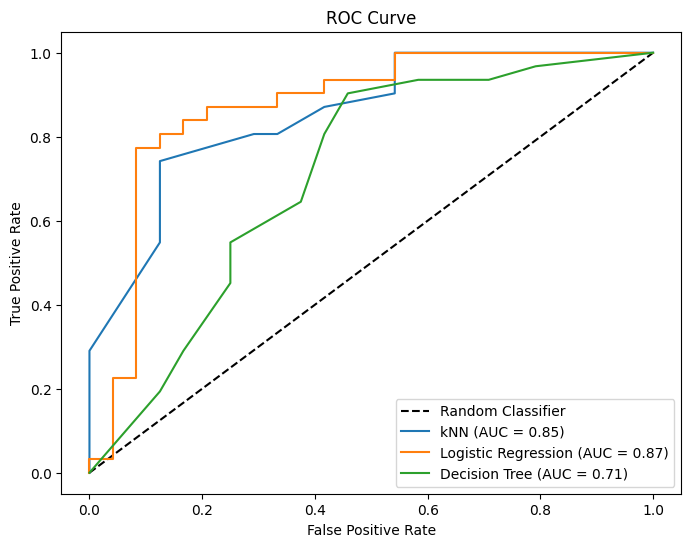

In [90]:
# identify models
models = {
    "kNN": (knn_y_pred, knn_y_pred_proba),
    "Logistic Regression": (log_y_pred, log_y_pred_proba),
    "Decision Tree": (tree_y_pred, tree_y_pred_proba)
}

# Metrics for each model
results = []

for name, (y_pred, y_prob) in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(pd.get_dummies(y_test), y_prob, multi_class='ovr') if y_prob is not None else None
    
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc
    })
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for {name}:\n{cm}")

# Results as a DataFrame
results_df = pd.DataFrame(results)
print("\nEvaluation Metrics:\n", results_df)

# Plot ROC Curves for each model
plt.figure(figsize=(8, 6))

# Plot the random classifier line (diagonal line)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

for name, (_, y_prob) in models.items():
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
        # Calculate AUC for the model
        auc_score = roc_auc_score(y_test, y_prob[:, 1])
        # Plot ROC curve with AUC in the label
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

plt.title(f"ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# Part Two: Metrics

Consider the following metrics:

* True Positive Rate or Recall or Sensitivity = Of the observations that are truly Class A, how many were predicted to be Class A?

* Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?

* True Negative Rate or Specificity or Negative Predictive Value = Of all the observations classified as NOT Class A, how many were truly NOT Class A?

Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One.

In [97]:
# write function to get classification metrics

def classification_metrics(y_test, y_pred):
    metrics = []
    # get confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # calculate metrics
    sensitivity = (cm[1, 1])/((cm[1, 1]) + (cm[1, 0]))
    precision = (cm[1, 1])/((cm[1, 1]) + (cm[0, 1]))
    specificity = (cm[0, 0])/((cm[0, 0])+ (cm[0, 1]))
    # add values to empty list
    metrics.append({
        "Sensitivity": sensitivity,
        "Precision": precision,
        "Specificity": specificity
    })

    # convert to df
    metrics_df = pd.DataFrame(metrics)

    return metrics_df

# print out metrics for each model
knn_metrics = classification_metrics(y_test, knn_y_pred)
log_metrics = classification_metrics(y_test, log_y_pred)
tree_metrics = classification_metrics(y_test, tree_y_pred)

print("\nkNN Metrics:")
print(knn_metrics)
print("\nLogistic Regression Metrics:")
print(log_metrics)
print("\nDecision Tree Metrics:")
print(tree_metrics)



kNN Metrics:
   Sensitivity  Precision  Specificity
0     0.806452    0.78125     0.708333

Logistic Regression Metrics:
   Sensitivity  Precision  Specificity
0     0.870968   0.818182         0.75

Decision Tree Metrics:
   Sensitivity  Precision  Specificity
0     0.612903   0.703704     0.666667


kNN Metrics:
   Sensitivity  Precision  Specificity
0     0.806452    0.78125     0.708333

Logistic Regression Metrics:
   Sensitivity  Precision  Specificity
0     0.870968   0.818182         0.75

Decision Tree Metrics:
   Sensitivity  Precision  Specificity
0     0.612903   0.703704     0.666667


# Part Three: Discussion

Suppose you have been hired by a hospital to create classification models for heart attack risk.

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:

* Which metric(s) you would use for model selection and why.

* Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

* What score you should expect for your chosen metric(s) using your chosen model to predict future observations.

## Q1
The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

The metric that we would use in this scenario would be sensitivity, as it minimizes the most false negatives. Looking at the sensitivity measures across models, the logistic regression has the highest overall (0.87), meaning that it is the most effective in correctly identifying the patients that are high-risk compared to the other models. We would expect a score of 0.87 as we would assume the model is generalizable beyond the training data and can be applied to future datasets.

## Q2
The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

## Q3
The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

## Q4
The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.




# Appendix

Sources:

* https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

